In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


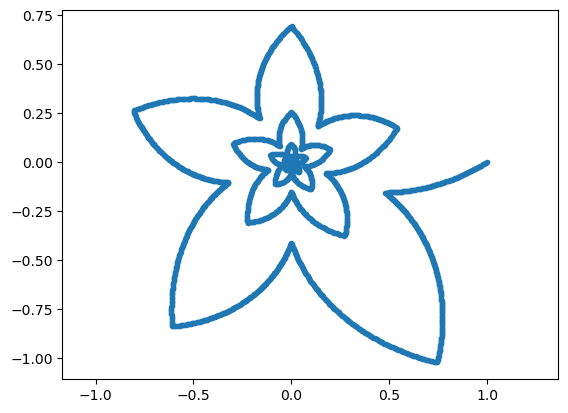

In [2]:
N = 2048
t = np.linspace(1/N, 1, N)
a = 2.0*np.pi*np.log(t)
r = t * (1.0+0.3*np.arcsin(np.sin(5.0*a)))
p = np.array([r*np.cos(a), r*np.sin(a)]).T

plt.plot(p[:, 0], p[:, 1], '.')
plt.axis('equal')
plt.show()

In [3]:
class Model(nn.Module):
    def __init__(self, ni, nh, no):
        super(Model, self).__init__()

        self.activation = torch.sin
        self.layer1 = nn.Linear(ni, nh)
        self.layer2 = nn.Linear(nh, nh)
        self.layer3 = nn.Linear(nh, nh)
        self.layer4 = nn.Linear(nh, nh)
        self.layer5 = nn.Linear(nh, nh)
        self.layer6 = nn.Linear(nh, no)

    def forward(self, x):
        xm = self.activation(self.layer1(x))
        xm = self.activation(self.layer2(xm))+xm
        xm = self.activation(self.layer3(xm))+xm
        xm = self.activation(self.layer4(xm))+xm
        xm = self.activation(self.layer5(xm))+xm
        return self.layer6(xm)

NZ = 16
NH = 32
ND = 2

encoder = Model(ND, NH, NZ).to(device)
decoder = Model(NZ, NH, ND).to(device)

print(encoder)
print(decoder)

Model(
  (layer1): Linear(in_features=2, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=32, bias=True)
  (layer4): Linear(in_features=32, out_features=32, bias=True)
  (layer5): Linear(in_features=32, out_features=32, bias=True)
  (layer6): Linear(in_features=32, out_features=16, bias=True)
)
Model(
  (layer1): Linear(in_features=16, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=32, bias=True)
  (layer4): Linear(in_features=32, out_features=32, bias=True)
  (layer5): Linear(in_features=32, out_features=32, bias=True)
  (layer6): Linear(in_features=32, out_features=2, bias=True)
)


In [18]:
def chamfer_distance(pc1, pc2):
    # Calculate pairwise distances
    pairwise_distances_pc1_pc2 = torch.cdist(pc1, pc2, p=2)
    pairwise_distances_pc2_pc1 = torch.cdist(pc2, pc1, p=2)

    # Find the nearest neighbors for each point
    nearest_neighbors_pc1 = torch.min(pairwise_distances_pc1_pc2, dim=1).values
    nearest_neighbors_pc2 = torch.min(pairwise_distances_pc2_pc1, dim=1).values

    # Calculate the Chamfer distance
    chamfer_loss = torch.mean(nearest_neighbors_pc1) + torch.mean(nearest_neighbors_pc2)

    return chamfer_loss

def sinkhorn_distance(pc1, pc2, epsilon=0.1, n_iters=10):
    C = torch.cdist(pc1, pc2, p=2)  # Cost matrix
    K = torch.exp(-C / epsilon)

    u = torch.ones_like(pc1[:, 0]) / pc1.size(0)
    v = torch.ones_like(pc2[:, 0]) / pc2.size(0)

    for _ in range(n_iters):
        u = 1.0 / torch.sum(K * v, dim=1)
        v = 1.0 / torch.sum(K.t() * u, dim=1)

    P = torch.diag(u) @ K @ torch.diag(v)

    sinkhorn_loss = torch.sum(P * C)
    return sinkhorn_loss


data = torch.tensor(p, dtype=torch.float32, device=device)

optimizer_e = torch.optim.Adam(
    encoder.parameters(),
    lr=0.002
)
optimizer_d = torch.optim.Adam(
    decoder.parameters(),
    lr=0.002
)

soboleng = torch.quasirandom.SobolEngine(dimension=NZ)

def rand_lds(n):
    u = soboleng.draw(n).to(device)
    return torch.erfinv(1.9999*(u-0.5))


batch_size = 256

for batch_i in range(100000):
    i = torch.arange(0, batch_size, dtype=torch.int64, device=device)
    i = ((i + batch_i*batch_size) * 131407079) % len(data)

    x = data[i]
    z = encoder(x)
    y = decoder(z)
    # loss_diff = 0.5 * torch.mean(torch.abs(y-x))
    loss_diff = torch.mean((y-x)**2)
    # loss_diff = 0.5 * loss_diff + 0.2 * loss_diff ** 0.5
    # loss_diff = 0.5 * torch.mean((y-x)**2) ** 0.5

    z = rand_lds(batch_size)
    y = decoder(z)
    loss_vae = 0.01 * sinkhorn_distance(y, x)

    loss = loss_diff + loss_vae

    encoder.zero_grad()
    decoder.zero_grad()
    loss.backward()
    optimizer_e.step()
    optimizer_d.step()

    if (batch_i+1) % 1000 == 0:
        print('%d diff %.4f, vae %.4f, total %.4f' % (
            batch_i+1, loss_diff.item(), loss_vae.item(), loss.item()))


1000 diff 0.0001, vae 0.3822, total 0.3824
2000 diff 0.0001, vae 0.3806, total 0.3807
3000 diff 0.0001, vae 0.3766, total 0.3767
4000 diff 0.0001, vae 0.3824, total 0.3825
5000 diff 0.0001, vae 0.3800, total 0.3801
6000 diff 0.0001, vae 0.3816, total 0.3817
7000 diff 0.0001, vae 0.3788, total 0.3789
8000 diff 0.0001, vae 0.3793, total 0.3794
9000 diff 0.0001, vae 0.3799, total 0.3800
10000 diff 0.0002, vae 0.3782, total 0.3783
11000 diff 0.0002, vae 0.3761, total 0.3763
12000 diff 0.0001, vae 0.3790, total 0.3791
13000 diff 0.0001, vae 0.3768, total 0.3769
14000 diff 0.0001, vae 0.3801, total 0.3802
15000 diff 0.0001, vae 0.3785, total 0.3786
16000 diff 0.0001, vae 0.3806, total 0.3807


KeyboardInterrupt: 

(2048, 2)


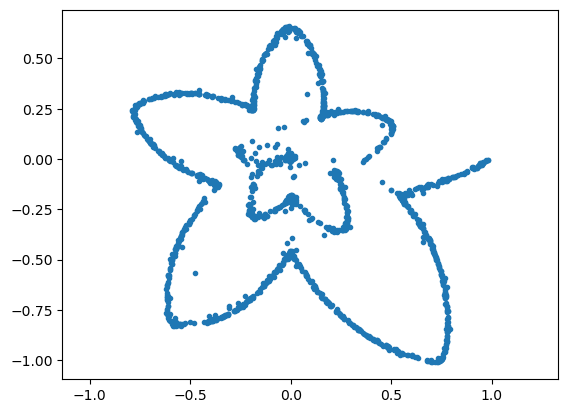

In [19]:
z = rand_lds(2048)

with torch.no_grad():
    y = decoder(z)

y = y.detach().cpu().numpy()
print(y.shape)

plt.plot(y[:, 0], y[:, 1], '.')
plt.axis('equal')
plt.show()